In [8]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd

import utils.visualization_utils as visualization_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils

import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]

# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"

HYAK_OUTPUT_DIR = "/data/patrick_res/hyak/pseudo/"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"


PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms
NUM_BINS_SMOOTH = 1

Text(0, 0.5, 'Decoder Accuracy')

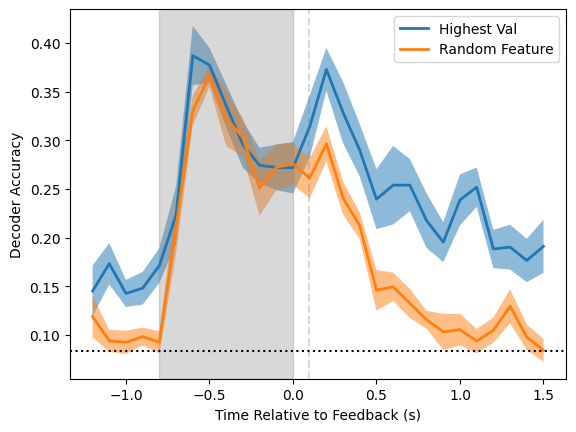

In [3]:
fig, ax = plt.subplots()
high_val_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, "high_val_MaxFeat_rpe_sess_test_accs.npy"))
random_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, "high_val_RandomMaxFeat_rpe_sess_test_accs.npy"))
visualization_utils.visualize_accuracy_across_time_bins(
    high_val_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Highest Val",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    random_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Random Feature",
    right_align=True, 
)
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(1/12, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

### Plot weights against baseline

In [12]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(valid_sess)
positions = positions[positions.manual_structure != "unknown"]

In [14]:
normalizeds = []
model_names = ["MaxFeat", "RandomMaxFeat"]
for i, model_name in enumerate(model_names):
    models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"high_val_{model_name}_rpe_sess_models.npy"), allow_pickle=True)
    # evaluate weights by time. Pass in number of neurons and number of classes
    weights = classifier_utils.evaluate_model_weights_by_time_bins(models, num_neurons=756, num_classes=12)
    # normalize weights so that they sum to 1
    sums = np.sum(weights, axis=0)
    normalized = weights / sums
    # max = np.max(weights, axis=1)
    # normalized = weights / max
    normalizeds.append(normalized)
all_weights = np.concatenate(normalizeds, axis=1)
means = np.mean(all_weights, axis=1)
means_df = pd.DataFrame({'np_idx': np.arange(len(means)), 'weight': means})

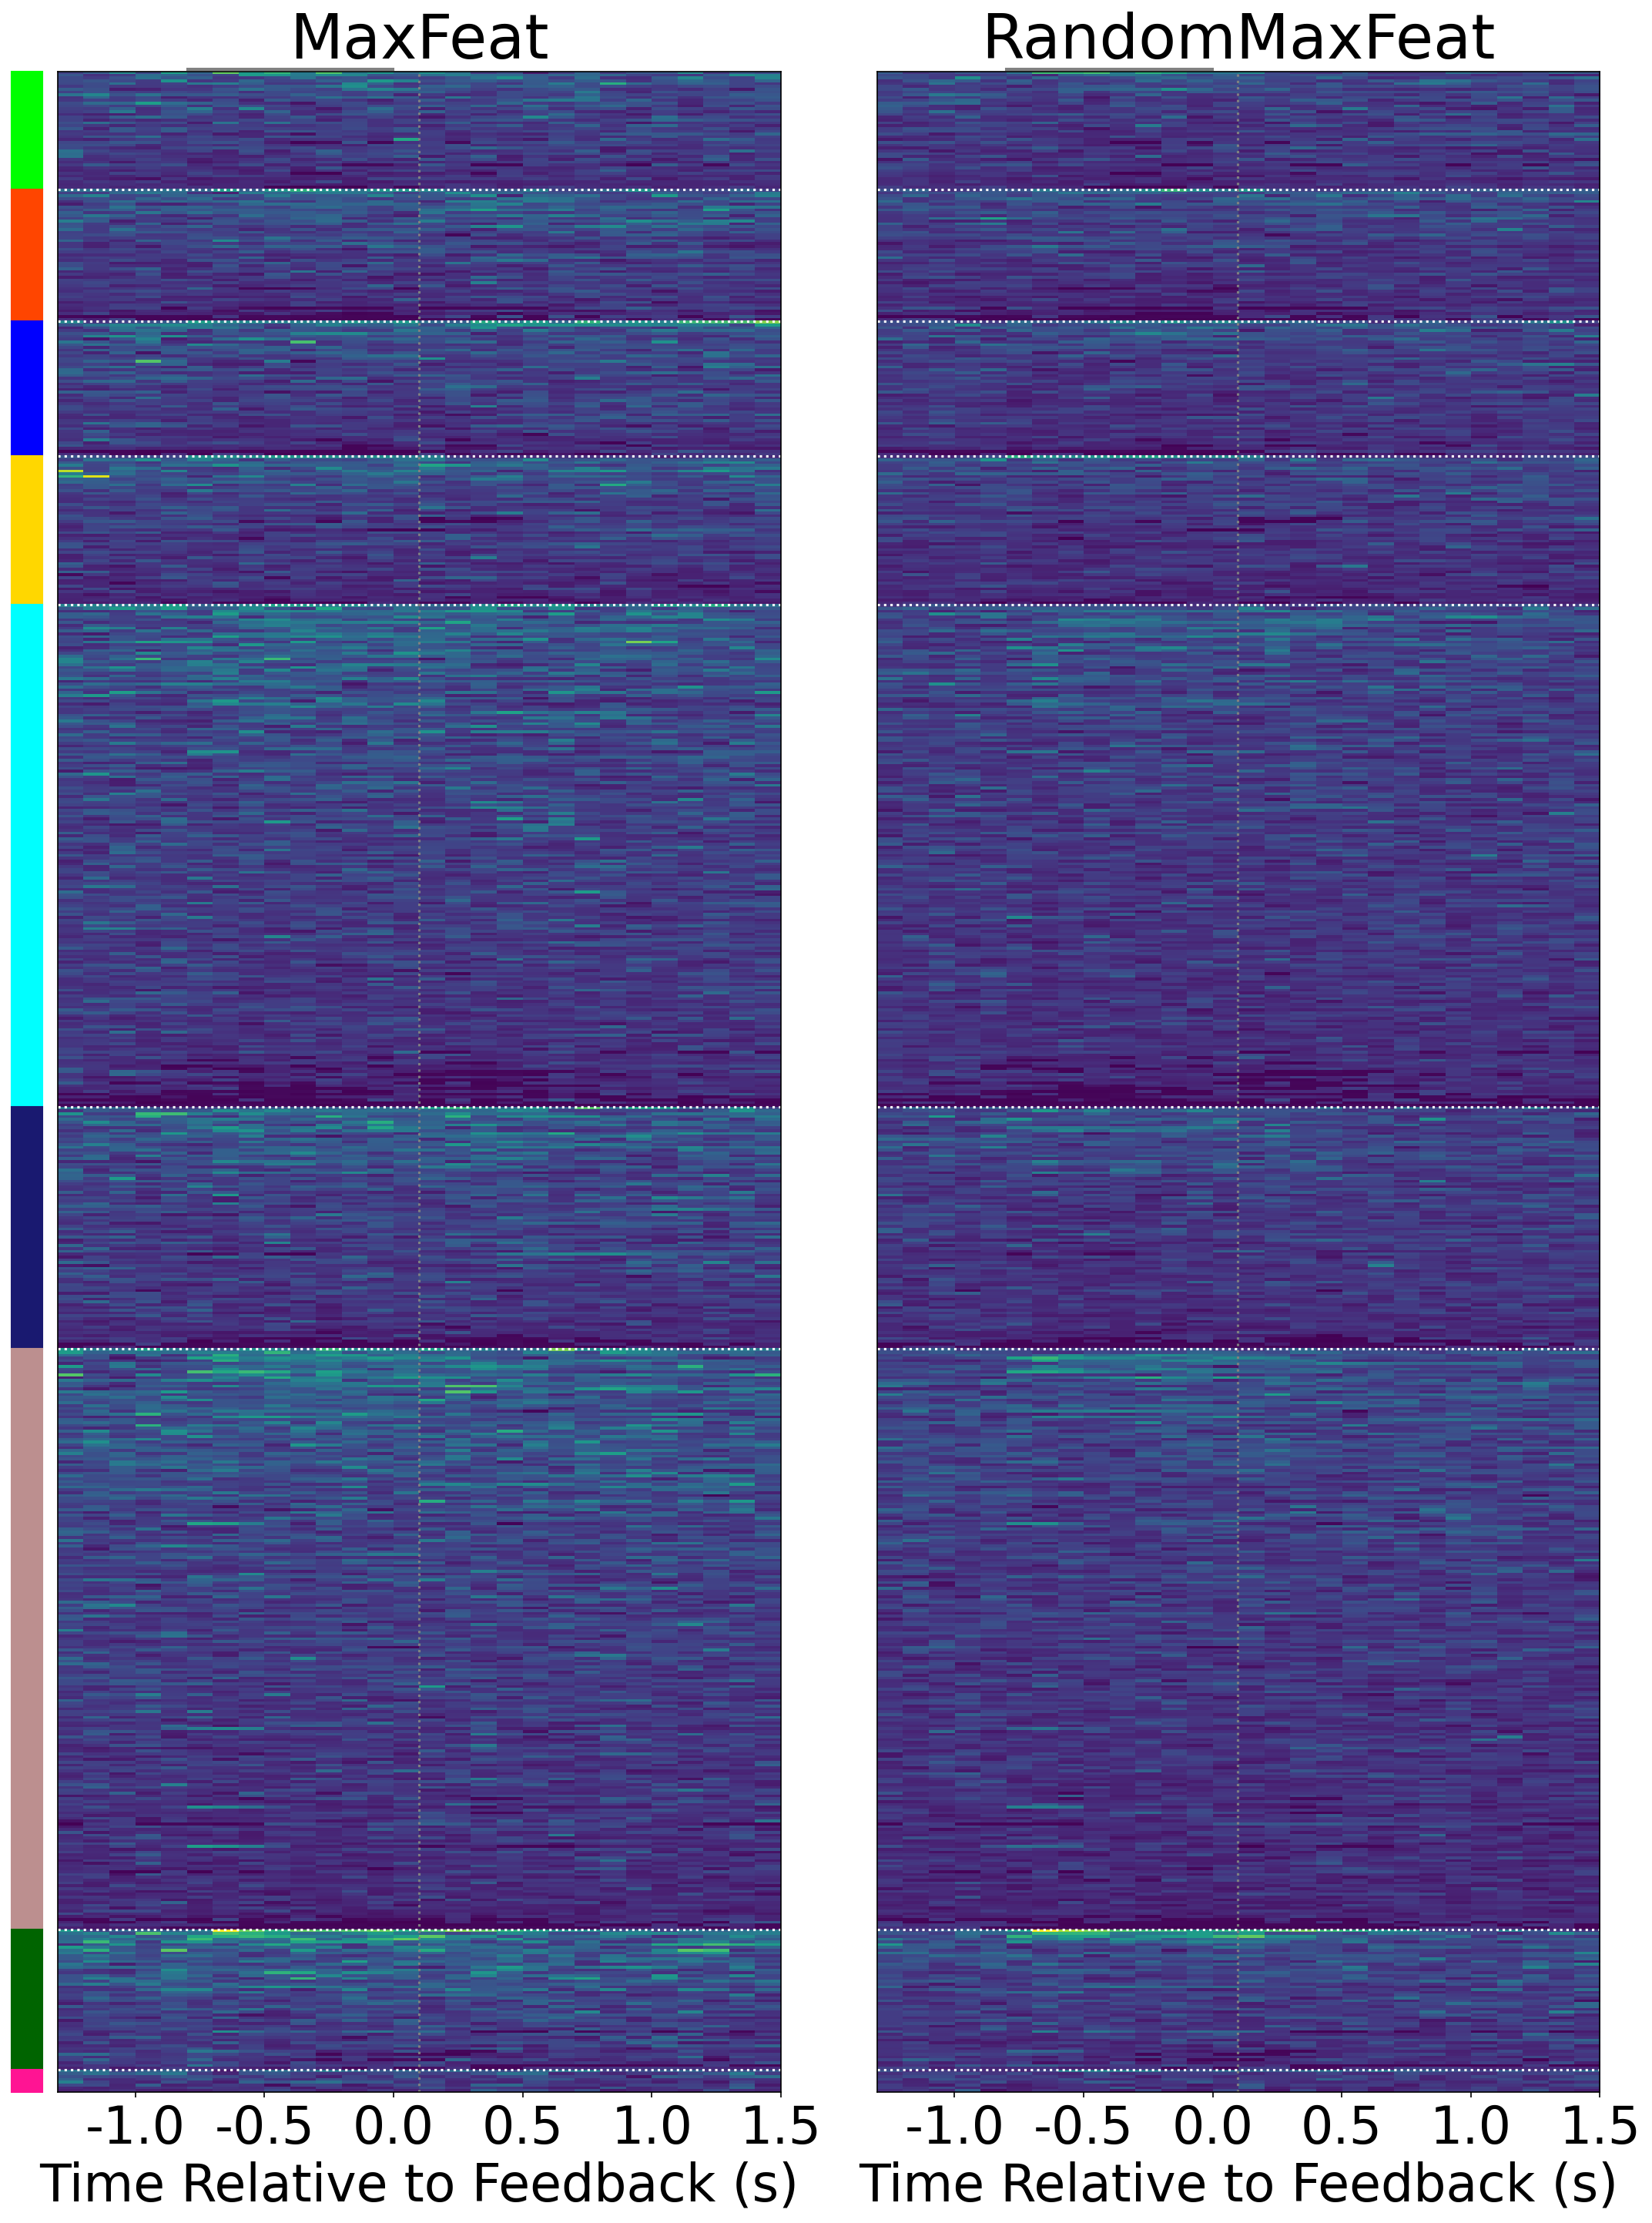

In [16]:

fig, axs = plt.subplots(1, 2, figsize=(15, 20), dpi=150, sharex=True)
matplotlib.rcParams.update({'font.size': 32})
for i, model_name in enumerate(model_names):
    add_region = i == 0
    visualization_utils.visualize_weights(
        positions, 
        normalizeds[i], 
        "manual_structure", 
        name_to_color=visualization_utils.REGION_TO_COLOR, 
        add_region=add_region, 
        mean_weights_df=means_df,
        ax=axs[i]
    )
    axs[i].set_title(model_name)
fig.tight_layout()

### Plot per-feature dim high val decoding

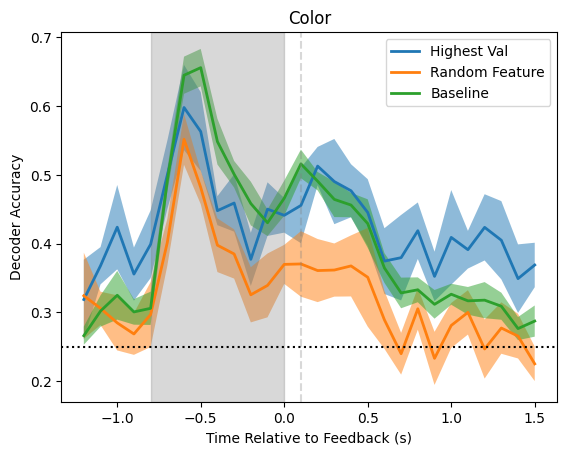

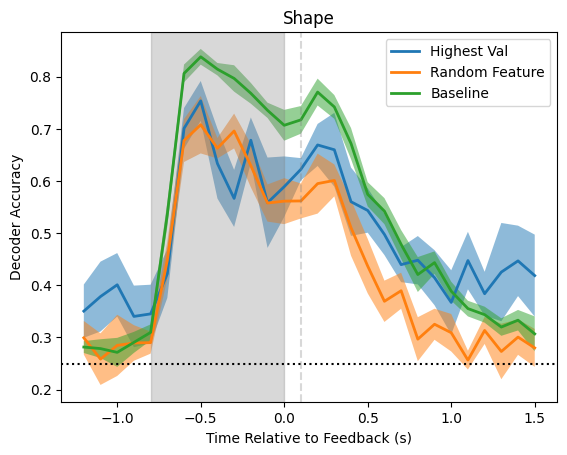

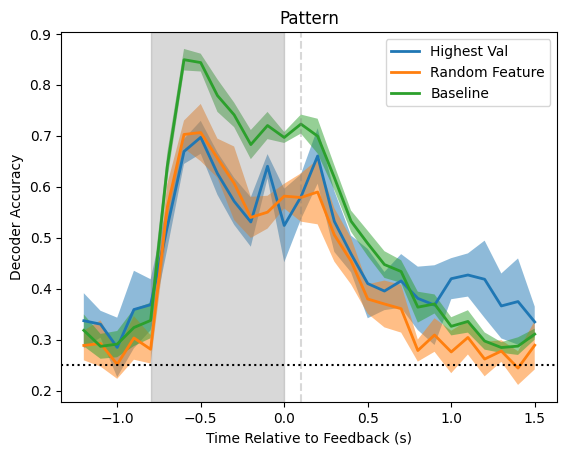

In [4]:
for feature_dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    high_val_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_high_val_MaxFeat_rpe_sess_test_accs.npy"))
    random_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_high_val_RandomMaxFeat_rpe_sess_test_accs.npy"))
    baseline_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_test_accs.npy"))

    visualization_utils.visualize_accuracy_across_time_bins(
        high_val_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Highest Val",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        random_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Random Feature",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        baseline_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Baseline",
        right_align=True, 
    )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(feature_dim)

### Look at weights of high val decoder, compare to feature decoders